# Waterfall.
Waterfall Classification dataset detalla incidentes de ciberseguridad que afectan a diversos sectores, con información sobre la fecha de publicación, la región, el tipo de actor de la amenaza, las consecuencias físicas o de otro tipo y un resumen del incidente. También incluye referencias para profundizar en cada caso.

## Importación de librerías.

In [1]:
# === Importación de librerías ===
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y clasificación
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Métricas de evaluación
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_score,
    recall_score,
)

# Balanceo de datos
from imblearn.over_sampling import RandomOverSampler

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Tabulación de resultados
from tabulate import tabulate

# === Configuración de colores ===
denexus_colors = ['#1B2D40', '#577596', '#C7262B', '#F85C37', '#FF8250', '#4A4A4A']
denexus_palette = sns.light_palette("#1B2D40", n_colors=100, as_cmap=True)

# === Configuración de Pandas ===
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Importación e información de dataframes.

In [2]:
df = pd.read_csv('./data/WATERFALL.csv', index_col=0) #tomamos la primera columna como índice
df.head()

,victim,published_date,region,industry,threat_actor,sites,cost,ot_or_physical_consecuences,incident_summary,references,published_year,waterfall_report_year,waterfall_report_name
id,,,,,,,,,,,,,
0,Stuxnet,2010-07-15,Iran,Process Mfg.,Nation State,1,NaN,Destroyed 1000 centrifuges at Natanz,Plant was infected by the Stuxnet worm in a ta...,"[""en.wikipedia.org/wiki/Stuxnet""]",2010,2023,2023 Threat Report. ICSSTRIVE & Waterfall Secu...
3,Iran's main oil export terminals,2012-04-22,Iran,Oil & Gas,Nation State,6,NaN,Shutdown 6 terminals,6 terminals ops. affected by Flame malware. Ne...,"[""bbc.com/news/world-middle-east-59062907"",""ir...",2012,2023,2023 Threat Report. ICSSTRIVE & Waterfall Secu...
7,Unknown Power Plant,2012-10-?,USA,Power,Unknown,1,NaN,Delayed turbine restart (thus power generation...,10 plant PCs were infected by Mariposa malware...,"[""us-cert.gov/sites/default/files/Monitors/ICS...",2012,2023,2023 Threat Report. ICSSTRIVE & Waterfall Secu...
12,German steel mill,2014-12-22,Germany,Metals & Mining,Unknown,1,NaN,"Caused ""massive damage"" to plant equipment",Sophisticated attack using spear phishing and ...,"[""bbc.com/news/technology-30575104""]",2014,2023,2023 Threat Report. ICSSTRIVE & Waterfall Secu...
15,"Prykarpattyaoblenergo, Chernivtsioblenergo, Ky...",2015-12-13,Ukraine,Power,Nation State,32,NaN,Power outage lasts up to 6 hours affecting 230...,First publicly known attack on a power grid oc...,"[""en.wikipedia.org/wiki/2015_Ukraine_power_gri...",2015,2023,2023 Threat Report. ICSSTRIVE & Waterfall Secu...


In [3]:
df.describe(include='all')

,victim,published_date,region,industry,threat_actor,sites,cost,ot_or_physical_consecuences,incident_summary,references,published_year,waterfall_report_year,waterfall_report_name
count,116,116,116,116,116,116.000000,14,116,116,116,116.000000,116.0,116
unique,116,106,51,10,4,NaN,13,116,116,116,NaN,NaN,1
top,Stuxnet,2022-02-28,USA,Discrete Mfg.,Ransomware,NaN,$60M,Destroyed 1000 centrifuges at Natanz,Plant was infected by the Stuxnet worm in a ta...,"[""en.wikipedia.org/wiki/Stuxnet""]",NaN,NaN,2023 Threat Report. ICSSTRIVE & Waterfall Secu...
freq,1,3,21,43,89,NaN,2,1,1,1,NaN,NaN,116
mean,NaN,NaN,NaN,NaN,NaN,5.379310,NaN,NaN,NaN,NaN,2020.637931,2023.0,NaN
std,NaN,NaN,NaN,NaN,NaN,17.177668,NaN,NaN,NaN,NaN,2.212205,0.0,NaN
min,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,2010.000000,2023.0,NaN
25%,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,2020.000000,2023.0,NaN
50%,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,2021.000000,2023.0,NaN
75%,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,2022.000000,2023.0,NaN


In [4]:
df.shape

(116, 13)

In [5]:
df.dtypes

victim                         object
published_date                 object
region                         object
industry                       object
threat_actor                   object
sites                           int64
cost                           object
ot_or_physical_consecuences    object
incident_summary               object
references                     object
published_year                  int64
waterfall_report_year           int64
waterfall_report_name          object
dtype: object

In [6]:
df.columns

Index(['victim', 'published_date', 'region', 'industry', 'threat_actor', 'sites', 'cost', 'ot_or_physical_consecuences', 'incident_summary', 'references', 'published_year', 'waterfall_report_year', 'waterfall_report_name'], dtype='object')

Next, we give a brief description of what each column is about.
1. **ID**: Incident identifier.
2. **Victim**: Name of the victim.
3. **Published date**: Publication date of the incident.
4. **Region**: Affected region.
5. **Industry**: Industry of the victim.
6. **Threat actor**: Threat actor.
7. **Sites**: Number of affected sites.
8. **Cost**: Cost of the incident.
9. **Physical consequences**: Consequences of the incident.
10. **Incident summary**: Summary of the incident.
11. **References**: Related references.
12. **Waterfall report year**: Year of the Waterfall report.
13. **Waterfall_report name**: Name of the report.

In [7]:
df.head(4)

,victim,published_date,region,industry,threat_actor,sites,cost,ot_or_physical_consecuences,incident_summary,references,published_year,waterfall_report_year,waterfall_report_name
id,,,,,,,,,,,,,
0,Stuxnet,2010-07-15,Iran,Process Mfg.,Nation State,1,NaN,Destroyed 1000 centrifuges at Natanz,Plant was infected by the Stuxnet worm in a ta...,"[""en.wikipedia.org/wiki/Stuxnet""]",2010,2023,2023 Threat Report. ICSSTRIVE & Waterfall Secu...
3,Iran's main oil export terminals,2012-04-22,Iran,Oil & Gas,Nation State,6,NaN,Shutdown 6 terminals,6 terminals ops. affected by Flame malware. Ne...,"[""bbc.com/news/world-middle-east-59062907"",""ir...",2012,2023,2023 Threat Report. ICSSTRIVE & Waterfall Secu...
7,Unknown Power Plant,2012-10-?,USA,Power,Unknown,1,NaN,Delayed turbine restart (thus power generation...,10 plant PCs were infected by Mariposa malware...,"[""us-cert.gov/sites/default/files/Monitors/ICS...",2012,2023,2023 Threat Report. ICSSTRIVE & Waterfall Secu...
12,German steel mill,2014-12-22,Germany,Metals & Mining,Unknown,1,NaN,"Caused ""massive damage"" to plant equipment",Sophisticated attack using spear phishing and ...,"[""bbc.com/news/technology-30575104""]",2014,2023,2023 Threat Report. ICSSTRIVE & Waterfall Secu...


## Limpieza de datos.
La columna **Waterfall Report Year** se eliminará del DataFrame para simplificar, ya que se refiere al año en que se publicó un informe específico relacionado con los incidentes o sucesos registrados en el DataFrame. Esto no proporciona información para el modelo de clasificación posterior.

In [8]:
df.drop(columns=['waterfall_report_year'], inplace=True)

Separaremos la columna **Published Date** en componentes de día, mes y año, cada uno de ellos como una columna diferente, convirtiéndola en un formato de fecha.

In [9]:
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')
df['day'] = df['published_date'].dt.day
df['month'] = df['published_date'].dt.month
df['year'] = df['published_date'].dt.year

Observamos que hay dos columnas que indican el año: **Published Year** y **Year**. Vamos a compararlas para identificar posibles discrepancias.

In [10]:
differences = df[df['year'] != df['published_year']]

print(f"There are {differences.shape[0]} rows where 'year' and 'year_1' are different.")
differences[['year', 'published_year']].head()

There are 4 rows where 'year' and 'year_1' are different.


,year,published_year
id,,
7,NaN,2012
43,NaN,2017
58,NaN,2019
252,NaN,2021


En este caso, se han encontrado diferencias debidas a campos vacíos en los valores extraídos de la columna **Published Date**. Sin embargo, esto no es un problema, ya que más adelante, cuando gestionemos los valores nulos, eliminaremos estas filas.

In [11]:
df.drop(columns=['published_year', 'published_date'], inplace=True)

### Tratamiento de filas duplicadas.

In [12]:
df.duplicated().sum()

0

In [13]:
df.drop_duplicates(inplace=True)

### Tratamiento de las filas nulas.

In [14]:
df.isnull().sum()

victim                           0
region                           0
industry                         0
threat_actor                     0
sites                            0
cost                           102
ot_or_physical_consecuences      0
incident_summary                 0
references                       0
waterfall_report_name            0
day                              4
month                            4
year                             4
dtype: int64

In [15]:
df.shape[0]

116

Eliminaremos la columna **Cost** ya que contiene en su mayoría valores nulos.

In [16]:
df.drop(columns=['cost'], inplace=True)

In [17]:
df.dropna(inplace=True)

In [18]:
df.shape

(112, 12)

### Selección de variables categóricas y continuas.
Para realizar correctamente un análisis de datos debemos distinguir entre variables categóricas, variables que representan diferentes categorías o grupos, y variables continuas, variables que pueden tomar cualquier valor dentro de un rango determinado.

In [19]:
v_continuas = []
v_categoricas = []
for i in df.columns:
    if df[i].nunique() > 25 or df[i].dtypes in ['float64', 'int64']:
        v_continuas.append(i)
    else:
        v_categoricas.append(i)

print('Variables continuous: {}'.format(', '.join(v_continuas)))
print('Variables categorical: {}'.format(', '.join(v_categoricas)))

Variables continuous: victim, region, sites, ot_or_physical_consecuences, incident_summary, references, day, month, year
Variables categorical: industry, threat_actor, waterfall_report_name


#### Manejo de Variables Categóricas.
Para el posterior modelo de clasificación, necesitamos codificar nuestras variables. Para ello, realizaremos una codificación ordinal que consiste en asignar valores enteros a las categorías en función de su posición o jerarquía en los datos.

In [20]:
df[v_categoricas].head(3)

,industry,threat_actor,waterfall_report_name
id,,,
0,Process Mfg.,Nation State,2023 Threat Report. ICSSTRIVE & Waterfall Secu...
3,Oil & Gas,Nation State,2023 Threat Report. ICSSTRIVE & Waterfall Secu...
12,Metals & Mining,Unknown,2023 Threat Report. ICSSTRIVE & Waterfall Secu...


In [21]:
df[v_categoricas].nunique()

industry                 10
threat_actor              4
waterfall_report_name     1
dtype: int64

Decidimos eliminar la columna **Waterfall Report Name** porque contiene un único valor en todas las filas. Este valor repetido no añade ninguna información útil ni variabilidad al conjunto de datos, por lo que su inclusión resulta innecesaria para posteriores análisis.

In [22]:
df.drop(columns=['waterfall_report_name'], inplace=True)

##### **Industry**.

In [23]:
df['industry'].unique()

array(['Process Mfg.', 'Oil & Gas', 'Metals & Mining', 'Power',
       'Discrete Mfg.', 'Transportation', 'All', 'Food & Beverage',
       'Agriculture', 'Water'], dtype=object)

Vamos a agrupar los distintos sectores en categorías más amplias para facilitar el análisis de los datos mediante la técnica **One Hot Encoding**. Esto nos permitirá convertir las categorías en columnas binarias que indiquen la presencia o ausencia de cada sector.

En el caso concreto de la categoría **All**, marcaremos con un 1 todas las columnas correspondientes a los sectores, ya que esta categoría representa la inclusión de todos los sectores en un mismo registro. Esta estrategia se lleva a cabo para garantizar que, durante el análisis de los datos, los sectores estén correctamente representados y se pueda evaluar eficazmente el impacto de cada uno de ellos.

In [24]:
industry_groups = {
    'Manufacturing': ['Process Mfg.', 'Discrete Mfg.'],
    'Energy': ['Oil & Gas', 'Power'],
    'Mining': ['Metals & Mining'],
    'Agriculture': ['Food & Beverage', 'Agriculture']
}

In [25]:
def replace_with_groups(sector):
    for group, sectors in industry_groups.items():
        if sector in sectors:
            return group
    return sector

In [26]:
df['industry_group'] = df['industry'].apply(replace_with_groups)

El siguiente código se ha agregado para lograr que las columnas codificadas se agreguen justo después de la columna original, de manera que sea más fácil ver a qué se le ha asignado el valor codificado.



In [27]:
columns = df.columns.tolist()
industry_index = columns.index('industry')

columns.insert(industry_index + 1, columns.pop(columns.index('industry_group')))
df = df[columns]

In [28]:
df.head(2)

,victim,region,industry,industry_group,threat_actor,sites,ot_or_physical_consecuences,incident_summary,references,day,month,year
id,,,,,,,,,,,,
0,Stuxnet,Iran,Process Mfg.,Manufacturing,Nation State,1,Destroyed 1000 centrifuges at Natanz,Plant was infected by the Stuxnet worm in a ta...,"[""en.wikipedia.org/wiki/Stuxnet""]",15.0,7.0,2010.0
3,Iran's main oil export terminals,Iran,Oil & Gas,Energy,Nation State,6,Shutdown 6 terminals,6 terminals ops. affected by Flame malware. Ne...,"[""bbc.com/news/world-middle-east-59062907"",""ir...",22.0,4.0,2012.0


In [29]:
df['industry_group'].unique()

array(['Manufacturing', 'Energy', 'Mining', 'Transportation', 'All',
       'Agriculture', 'Water'], dtype=object)

In [30]:
dummies = pd.get_dummies(df['industry_group'], prefix='industry_')
industry_all = (df['industry'] == 'All').astype(int)
dummies = dummies.where(industry_all == 0, 1)
dummies.drop(columns='industry__All', inplace=True)

El siguiente código se ha agregado para lograr que las columnas codificadas se agreguen justo después de la columna original, de manera que sea más fácil ver a qué se le ha asignado el valor codificado.



In [31]:
idx = df.columns.get_loc('industry_group') + 1

df_before = df.iloc[:, :idx]
df_after = df.iloc[:, idx:]

df = pd.concat([df_before, dummies, df_after], axis=1)

In [32]:
df.head(3)

,victim,region,industry,industry_group,industry__Agriculture,industry__Energy,industry__Manufacturing,industry__Mining,industry__Transportation,industry__Water,threat_actor,sites,ot_or_physical_consecuences,incident_summary,references,day,month,year
id,,,,,,,,,,,,,,,,,,
0,Stuxnet,Iran,Process Mfg.,Manufacturing,0,0,1,0,0,0,Nation State,1,Destroyed 1000 centrifuges at Natanz,Plant was infected by the Stuxnet worm in a ta...,"[""en.wikipedia.org/wiki/Stuxnet""]",15.0,7.0,2010.0
3,Iran's main oil export terminals,Iran,Oil & Gas,Energy,0,1,0,0,0,0,Nation State,6,Shutdown 6 terminals,6 terminals ops. affected by Flame malware. Ne...,"[""bbc.com/news/world-middle-east-59062907"",""ir...",22.0,4.0,2012.0
12,German steel mill,Germany,Metals & Mining,Mining,0,0,0,1,0,0,Unknown,1,"Caused ""massive damage"" to plant equipment",Sophisticated attack using spear phishing and ...,"[""bbc.com/news/technology-30575104""]",22.0,12.0,2014.0


##### **Threat Actor**.

In [33]:
df['threat_actor'].unique()

array(['Nation State', 'Unknown', 'Ransomware', 'Hacktivist'],
      dtype=object)

In [34]:
label_encoder = LabelEncoder()
df['threat_actor_encoded'] = label_encoder.fit_transform(df['threat_actor'])

El siguiente código se ha agregado para lograr que las columnas codificadas se agreguen justo después de la columna original, de manera que sea más fácil ver a qué se le ha asignado el valor codificado.


In [35]:
columns = df.columns.tolist()
index = columns.index('threat_actor')

columns.insert(index + 1, columns.pop(columns.index('threat_actor_encoded')))
df = df[columns]

In [36]:
df.head(2)

,victim,region,industry,industry_group,industry__Agriculture,industry__Energy,industry__Manufacturing,industry__Mining,industry__Transportation,industry__Water,threat_actor,threat_actor_encoded,sites,ot_or_physical_consecuences,incident_summary,references,day,month,year
id,,,,,,,,,,,,,,,,,,,
0,Stuxnet,Iran,Process Mfg.,Manufacturing,0,0,1,0,0,0,Nation State,1,1,Destroyed 1000 centrifuges at Natanz,Plant was infected by the Stuxnet worm in a ta...,"[""en.wikipedia.org/wiki/Stuxnet""]",15.0,7.0,2010.0
3,Iran's main oil export terminals,Iran,Oil & Gas,Energy,0,1,0,0,0,0,Nation State,1,6,Shutdown 6 terminals,6 terminals ops. affected by Flame malware. Ne...,"[""bbc.com/news/world-middle-east-59062907"",""ir...",22.0,4.0,2012.0


#### Manejo de variables continuas.
Para el modelo de clasificación debemos convertir todas las columnas a tipo int. Por lo tanto, debemos ver si debemos realizar una codificación ordinal como en el caso anterior o agruparlas.

Las variables continuas se dividen en variables numéricas y variables objeto, que son cadenas de texto que requieren codificación para su análisis. Aunque estas variables son continuas en el sentido de que pueden tomar muchos valores diferentes, se almacenan como cadenas de texto.

In [37]:
df[v_continuas].head(3)

,victim,region,sites,ot_or_physical_consecuences,incident_summary,references,day,month,year
id,,,,,,,,,
0,Stuxnet,Iran,1,Destroyed 1000 centrifuges at Natanz,Plant was infected by the Stuxnet worm in a ta...,"[""en.wikipedia.org/wiki/Stuxnet""]",15.0,7.0,2010.0
3,Iran's main oil export terminals,Iran,6,Shutdown 6 terminals,6 terminals ops. affected by Flame malware. Ne...,"[""bbc.com/news/world-middle-east-59062907"",""ir...",22.0,4.0,2012.0
12,German steel mill,Germany,1,"Caused ""massive damage"" to plant equipment",Sophisticated attack using spear phishing and ...,"[""bbc.com/news/technology-30575104""]",22.0,12.0,2014.0


In [38]:
df[v_continuas].dtypes

victim                          object
region                          object
sites                            int64
ot_or_physical_consecuences     object
incident_summary                object
references                      object
day                            float64
month                          float64
year                           float64
dtype: object

In [39]:
v_categoricas_cont = list(df[v_continuas].dtypes[df[v_continuas].dtypes == 'object'].index)

##### **Victim.**
La columna `victim` contiene valores que en su mayoría son únicos, lo que sugiere que actúa más como un identificador que como una característica con patrones generales útiles para el modelo. Transformarla directamente podría generar un exceso de categorías o introducir relaciones artificiales entre los valores, lo que podría afectar negativamente el rendimiento del modelo. Por este motivo, es mejor no transformar esta columna y evaluar su relevancia antes de incluirla en el análisis.

In [40]:
df['victim'].nunique()

112

##### **Region**.
Para realizar una evaluación más eficaz de los países de nuestros datos, es conveniente agruparlos por continentes. Esto es especialmente relevante porque en otros archivos CSV hay registros de ataques procedentes de distintos países, distribuidos por diferentes continentes.

Para facilitar este análisis, procederemos a crear seis nuevas columnas en nuestro conjunto de datos, cada una de las cuales representará un continente específico. Estas columnas indicarán con un valor 1 si el país pertenece al continente correspondiente y 0 en caso contrario, es decir, asignando valores binarios.

In [41]:
df['region'].unique()

array(['Iran', 'Germany', 'Ukraine', 'France, Slovenia, Romania, India',
       'India', 'Global', 'USA', 'Taiwan', 'Norway', 'South Africa',
       'Belgium, Romania, China', 'Australia', 'USA & Canada',
       'New Zealand', 'Japan, Turkey, UK, USA',
       'Germany, France, Malaysia, USA', 'Israel', 'Canada',
       'India, UK, Brazil, Russia, USA', 'Europe, N. & S. America, Asia',
       'USA, Canada, UK', 'France', 'Netherlands', 'UK',
       'Australia, Canada, USA', 'USA, Europe, S. America', 'Spain',
       'Switzerland, Germany', 'Belgium, Africa',
       'Malta, Belgium, Netherlands', 'Switzerland', 'N. & S. America',
       'Belarus', 'Japan', 'Russia', 'Greece', 'Bulgaria', 'Costa Rica',
       'USA & Europe', 'Mexico', 'UK, USA', 'Austria',
       'Austria, Canada, Finland, USA', 'Ghana', 'Germany, USA',
       'Denmark', 'Finland', 'Italy', 'Luxembourg', 'Colombia'],
      dtype=object)

In [42]:
continents_mapping = {
    'Africa': ['Ghana', 'South Africa', 'Nigeria', 'Kenya', 'Egypt', 'Morocco', 'Zimbabwe', 'Algeria'],
    'Asia': ['Asia', 'Iran', 'India', 'Japan', 'Taiwan', 'Malaysia', 'China', 'Turkey', 'Israel', 'Saudi Arabia', 'Russia'],
    'Europe': ['Germany', 'France', 'UK', 'Italy', 'Belgium', 'Austria', 'Sweden', 'Spain', 'Norway', 'Finland', 
               'Switzerland', 'Ukraine', 'Romania', 'Denmark', 'Bulgaria', 'Greece', 'Malta', 'Portugal', 
               'Netherlands', 'Czech Republic', 'Luxembourg', 'Belarus', 'Europe'],
    'North America': ['USA', 'Canada', 'Mexico', 'Belize', 'Costa Rica', 'El Salvador', 'Guatemala', 
                     'Honduras', 'Nicaragua', 'Panama', 'N.'],
    'South America': ['Brazil', 'Colombia', 'Argentina', 'Chile', 'Peru', 'Venezuela',
                      'S. America'],
    'Australia': ['Australia', 'New Zealand'],
    'Africa, Asia, North America, Europe, South America, Australia': ['Global']
}

In [43]:
def assign_continent(region):
    region = region.replace('&', ',')
    countries = [country.strip() for country in region.split(',')]
    continents = set()
    
    for country in countries:
        for continent, countries_list in continents_mapping.items():
            if country in countries_list:
                continents.add(continent)
    
    # Devolver una lista de continentes, unirlos como una cadena
    return ', '.join(continents) if continents else None

# Crear una nueva columna en el DataFrame con los continentes
df['continent'] = df['region'].apply(assign_continent)

In [44]:
countries_with_no_continent = df[df['continent'].isnull()]['region'].unique()

# Mostrar la lista de países con 'continent' como None
print("Lista de países con 'continent' como None:")
print(countries_with_no_continent)

Lista de países con 'continent' como None:
[]


In [45]:
continent_dummies = df['continent'].str.get_dummies(sep=', ')
df = pd.concat([df, continent_dummies], axis=1)

In [46]:
df.drop(columns=['region', 'continent'], inplace=True)

In [47]:
df.head(2)

,victim,industry,industry_group,industry__Agriculture,industry__Energy,industry__Manufacturing,industry__Mining,industry__Transportation,industry__Water,threat_actor,threat_actor_encoded,sites,ot_or_physical_consecuences,incident_summary,references,day,month,year,Africa,Asia,Australia,Europe,North America,South America
id,,,,,,,,,,,,,,,,,,,,,,,,
0,Stuxnet,Process Mfg.,Manufacturing,0,0,1,0,0,0,Nation State,1,1,Destroyed 1000 centrifuges at Natanz,Plant was infected by the Stuxnet worm in a ta...,"[""en.wikipedia.org/wiki/Stuxnet""]",15.0,7.0,2010.0,0,1,0,0,0,0
3,Iran's main oil export terminals,Oil & Gas,Energy,0,1,0,0,0,0,Nation State,1,6,Shutdown 6 terminals,6 terminals ops. affected by Flame malware. Ne...,"[""bbc.com/news/world-middle-east-59062907"",""ir...",22.0,4.0,2012.0,0,1,0,0,0,0


##### **OT or Physical Consecuences.**
La columna `OT or Physical Consecuences` contiene valores que en su mayoría son únicos, lo que sugiere que actúa más como un identificador que como una característica con patrones generales útiles para el modelo. Transformarla directamente podría generar un exceso de categorías o introducir relaciones artificiales entre los valores, lo que podría afectar negativamente el rendimiento del modelo. Por este motivo, es mejor no transformar esta columna y evaluar su relevancia antes de incluirla en el análisis.

In [48]:
df['ot_or_physical_consecuences'].nunique()

112

##### **Incident Summary.**
La columna `Incident Summary` contiene valores que en su mayoría son únicos, lo que sugiere que actúa más como un identificador que como una característica con patrones generales útiles para el modelo. Transformarla directamente podría generar un exceso de categorías o introducir relaciones artificiales entre los valores, lo que podría afectar negativamente el rendimiento del modelo. Por este motivo, es mejor no transformar esta columna y evaluar su relevancia antes de incluirla en el análisis.

In [49]:
df['incident_summary'].nunique()

112

##### **References**.
This column will be used later to define the relationships between CSVs. We will need to extract the domain name from the URL.

In [50]:
def clean_references(references):
    references = references.strip("[]")
    references = references.replace('"', '').replace("'", '')
    references = references.replace(',', ', ')

    references = re.sub(r'(\.com|\.org|\.es|\.net|\.co|\.gov|\.edu|\.int|\.mil)[^\s,]*', r'\1', references)
    
    return references

# Aplicar la función a la columna 'references'
df['references'] = df['references'].apply(clean_references)

In [51]:
df.head(3)

,victim,industry,industry_group,industry__Agriculture,industry__Energy,industry__Manufacturing,industry__Mining,industry__Transportation,industry__Water,threat_actor,threat_actor_encoded,sites,ot_or_physical_consecuences,incident_summary,references,day,month,year,Africa,Asia,Australia,Europe,North America,South America
id,,,,,,,,,,,,,,,,,,,,,,,,
0,Stuxnet,Process Mfg.,Manufacturing,0,0,1,0,0,0,Nation State,1,1,Destroyed 1000 centrifuges at Natanz,Plant was infected by the Stuxnet worm in a ta...,en.wikipedia.org,15.0,7.0,2010.0,0,1,0,0,0,0
3,Iran's main oil export terminals,Oil & Gas,Energy,0,1,0,0,0,0,Nation State,1,6,Shutdown 6 terminals,6 terminals ops. affected by Flame malware. Ne...,"bbc.com, iranprimer.usip.org",22.0,4.0,2012.0,0,1,0,0,0,0
12,German steel mill,Metals & Mining,Mining,0,0,0,1,0,0,Unknown,3,1,"Caused ""massive damage"" to plant equipment",Sophisticated attack using spear phishing and ...,bbc.com,22.0,12.0,2014.0,0,0,0,1,0,0


## Modelos de Clasificación.
En este análisis desarrollaremos modelos de clasificación para identificar patrones y predecir ciberataques. Utilizaremos **Threat Actor Encoded** como variable objetivo, ya que representa diferentes tipos de actores detrás de los ataques. Diferenciaremos entre **modelos supervisados**, que utilizan esta variable, y **no supervisados**, que buscan patrones sin depender de un objetivo. Para los modelos supervisados, realizaremos evaluación cruzada para medir su generalización.

In [52]:
df_1 = df.drop(list(df.select_dtypes(include=['object']).columns), axis = 1)

### Matriz de Confusión.

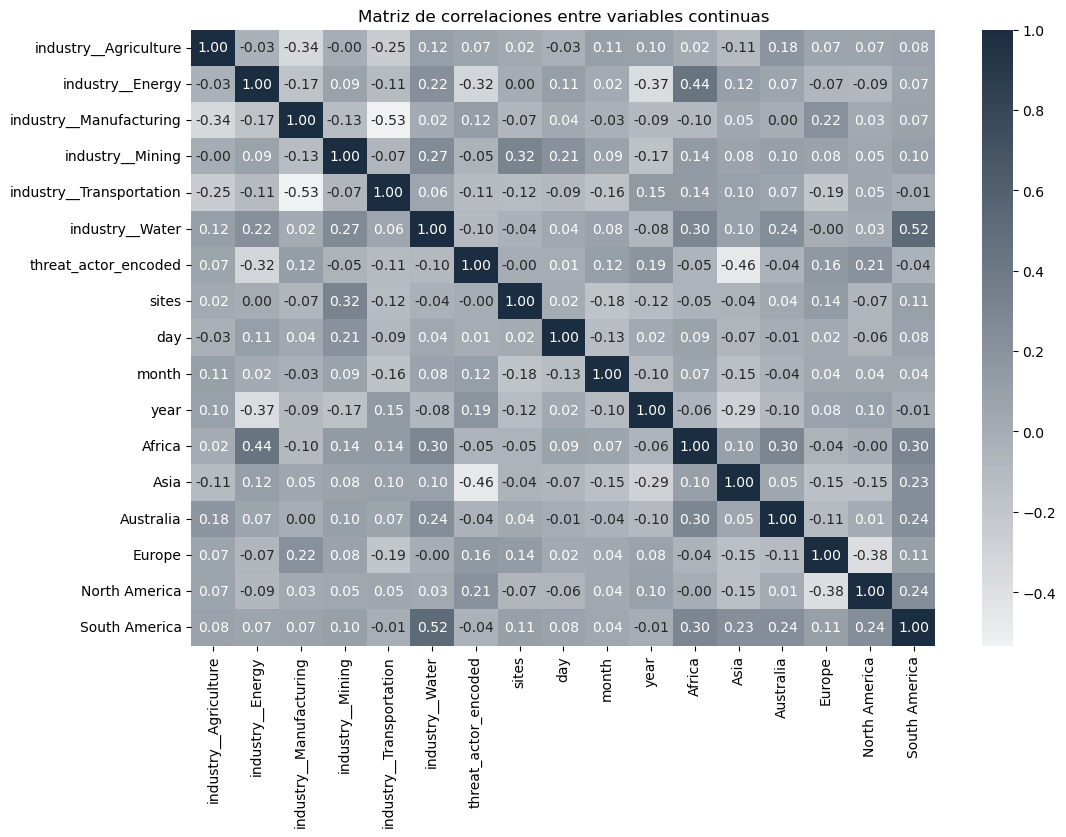

In [53]:
correlation_matrix = df_1.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=denexus_palette, cbar=True, fmt=".2f")
plt.title('Matriz de correlaciones entre variables continuas')
plt.show()

### Modelos de Clasificación Supervisado.
Hemos seleccionado **Threat Actor Encoded** como la variable objetivo porque representa diferentes tipos de actores detrás de ciberataques. Este análisis se centra en predecir el tipo de amenaza que se encuentra detrás de cada incidente, lo cual tiene un impacto directo en la planificación de estrategias de defensa. Aunque no es una variable binaria, este problema multiclase permite capturar patrones más complejos en los datos.

#### División en Conjuntos de Entrenamiento y Prueba.

In [54]:
X = df_1.drop(columns=['threat_actor_encoded'])
y = df_1['threat_actor_encoded']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
y_train.value_counts()

2    71
3     9
0     5
1     4
Name: threat_actor_encoded, dtype: int64

In [57]:
y_test.value_counts()

2    16
3     4
1     2
0     1
Name: threat_actor_encoded, dtype: int64

Al tener un **conjunto de entrenamiento muy desbalanceado**, lo óptimo para un correcto modelo de aprendizaje automático sería realizar un **balanceo de las clases** a través de **ROS** ya que este funciona mejor apra variables categóricas que **SMOTE**. Sin embargo, este balanceo no debe aplicarse al conjunto de prueba, ya que hacerlo alteraría la naturaleza de los datos, haciéndolos no representativos de la realidad. El **conjunto de prueba** debe reflejar fielmente la distribución de clases en el mundo real. Por lo tanto, en lugar de aplicar balanceo en el conjunto de prueba, lo que se hará será **asignar mayor importancia a las clases minoritarias** durante el entrenamiento del modelo, ajustando los pesos de las clases en el modelo. De este modo, el modelo aprenderá a prestar más atención a las clases con menos representaciones, sin comprometer la integridad del conjunto de prueba.

#### Manejo de variables desbalanceadas.
Dado el desbalance de clases en el conjunto de entrenamiento, vamos a aplicar **Random Over-Sampling (ROS)** para equilibrar las clases minoritarias. Esta técnica aumenta la representación de las clases menos frecuentes duplicando aleatoriamente sus instancias, lo que permite que el modelo aprenda de manera más equitativa.

In [58]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

#### Entrenamiento y Evaluación de Modelos.
En este apartado, entrenaremos modelos de aprendizaje supervisado para predecir el tipo de actor detrás de los ciberataques.

In [59]:
results = pd.DataFrame(columns=['Model', 'Tipo', 'Accuracy', 'Recall'])
results['Tipo'] = ['LabelEncoder']*2

##### **Random Forest.**
**Random Forest** es un algoritmo de aprendizaje automático basado en la creación de múltiples árboles de decisión, cuyos resultados se combinan para mejorar la precisión y evitar el sobreajuste. Es eficaz para clasificación y regresión, **manejando bien el desbalance de clases** y datos complejos.

In [60]:
class_weights= {0: 1, 1: 1, 2: 1, 3: 6} # pesos de las clases, para dar mas importancia a las clases minoritarias.
rf_model = RandomForestClassifier(class_weight=class_weights,
                                  random_state=42,
                                  n_estimators=100,
                                  min_samples_split=5)
rf_model.fit(X_train_ros, y_train_ros)

RandomForestClassifier(class_weight={0: 1, 1: 1, 2: 1, 3: 6},
                       min_samples_split=5, random_state=42)

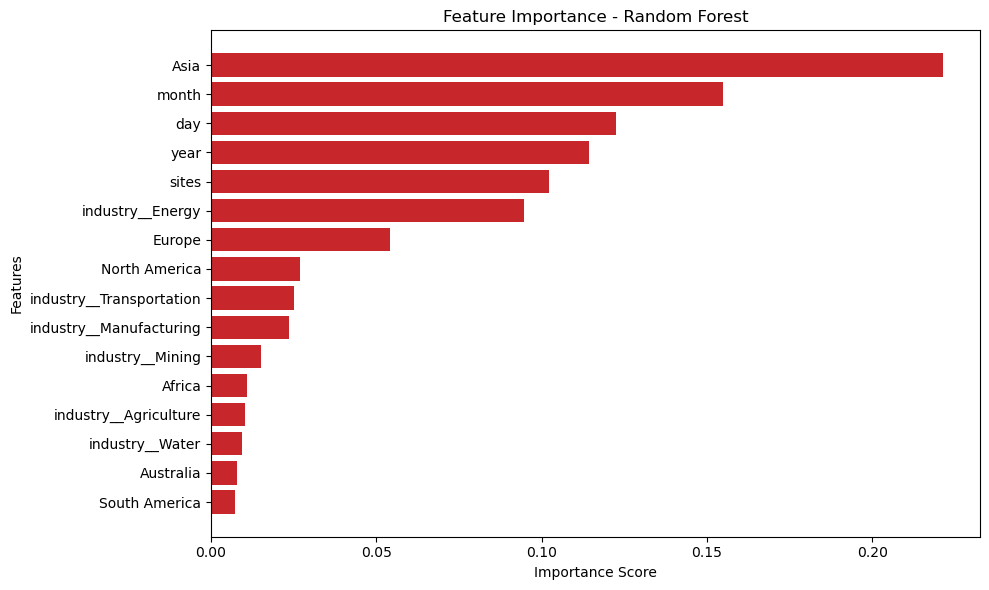

In [61]:
feature_importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center', color=denexus_colors[2])
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "feature-importance_random-forest.png")
    plt.savefig(output_path)
plt.show()

In [62]:
cv_scores = cross_val_score(rf_model, X_train_ros, y_train_ros, cv=5, scoring='accuracy')
cv_scores

array([0.92982456, 0.98245614, 0.98245614, 0.98245614, 0.94642857])

In [63]:
print("Train set score (Accuracy) =", rf_model.score(X_train_ros, y_train_ros))
print("Test set score (Accuracy) =", rf_model.score(X_test, y_test))

conf_mat = confusion_matrix(y_test, rf_model.predict(X_test))

print(tabulate(conf_mat, 
               headers=[f'Pred Class {i}' for i in range(4)], 
               showindex=[f'Real Class {i}' for i in range(4)], 
               tablefmt='fancy_grid'))

print("\nClassification Report:")
print(classification_report(y_test, rf_model.predict(X_test)))

Train set score (Accuracy) = 0.9964788732394366
Test set score (Accuracy) = 0.6956521739130435
╒══════════════╤════════════════╤════════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │   Pred Class 2 │   Pred Class 3 │
╞══════════════╪════════════════╪════════════════╪════════════════╪════════════════╡
│ Real Class 0 │              0 │              0 │              1 │              0 │
├──────────────┼────────────────┼────────────────┼────────────────┼────────────────┤
│ Real Class 1 │              0 │              1 │              1 │              0 │
├──────────────┼────────────────┼────────────────┼────────────────┼────────────────┤
│ Real Class 2 │              1 │              1 │             14 │              0 │
├──────────────┼────────────────┼────────────────┼────────────────┼────────────────┤
│ Real Class 3 │              0 │              0 │              3 │              1 │
╘══════════════╧════════════════╧════════════════╧═════

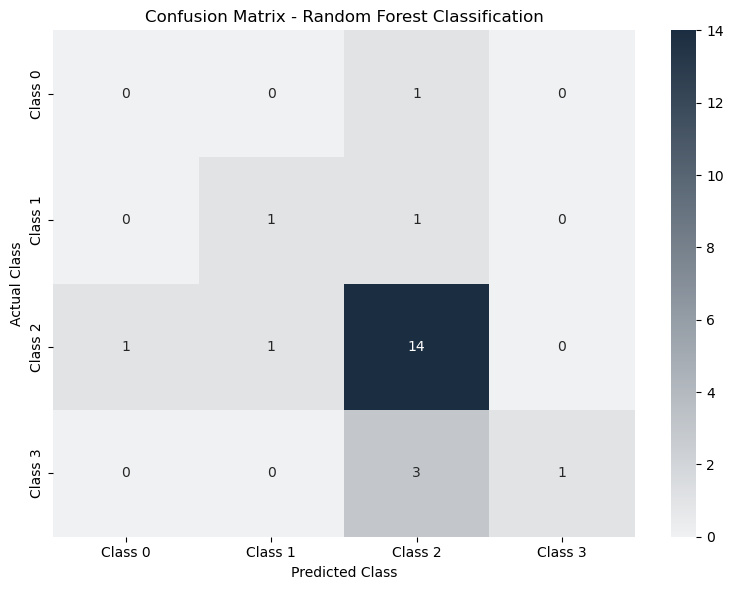

In [64]:
class_labels = [f'Class {i}' for i in range(conf_mat.shape[0])]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=denexus_palette,
            xticklabels=class_labels, yticklabels=class_labels, cbar=True)
plt.title('Confusion Matrix - Random Forest Classification')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "confusion-matrix_random-forest.png")
    plt.savefig(output_path)
plt.show()

**Conclusiones.**

En los resultados mostrados, el modelo muestra un alto rendimiento en el conjunto de **entrenamiento**. Sin embargo, en el conjunto de **prueba**, la precisión es más baja, lo que indica que el modelo no generaliza tan bien a datos no vistos. Esto es común cuando el modelo está muy ajustado al conjunto de entrenamiento, posiblemente debido a un sobreajuste.

El reporte de clasificación muestra que, para algunas clases, el modelo tiene un buen rendimiento en términos de **precisión** y **recall**, especialmente para la clase con más representaciones. No obstante, para las clases minoritarias, el rendimiento es más bajo, reflejando que, aunque se aplicó **oversampling** y se asignaron **pesos** a las clases minoritarias, el modelo aún tiene dificultades para predecir correctamente estas clases menos representadas.

La **precisión** general del modelo en el conjunto de prueba no es excelente debido al desbalance persistente, aunque el ajuste de pesos y el oversampling han ayudado a mejorar el rendimiento respecto a las clases más representadas. La **media ponderada** de las métricas es razonablemente alta, lo que indica que, en promedio, el modelo tiene un desempeño aceptable, aunque todavía podría mejorarse, especialmente en las clases minoritarias.

##### **Arbol de Decisión.**
Un Árbol de Decisión es un modelo útil para tareas de clasificación y regresión en aprendizaje automático. Es un modelo de decisión jerárquica que toma decisiones en función de las características de los datos y las distribuye en ramas, con cada nodo representando una prueba de una característica.

In [65]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_ros, y_train_ros)

DecisionTreeClassifier(random_state=42)

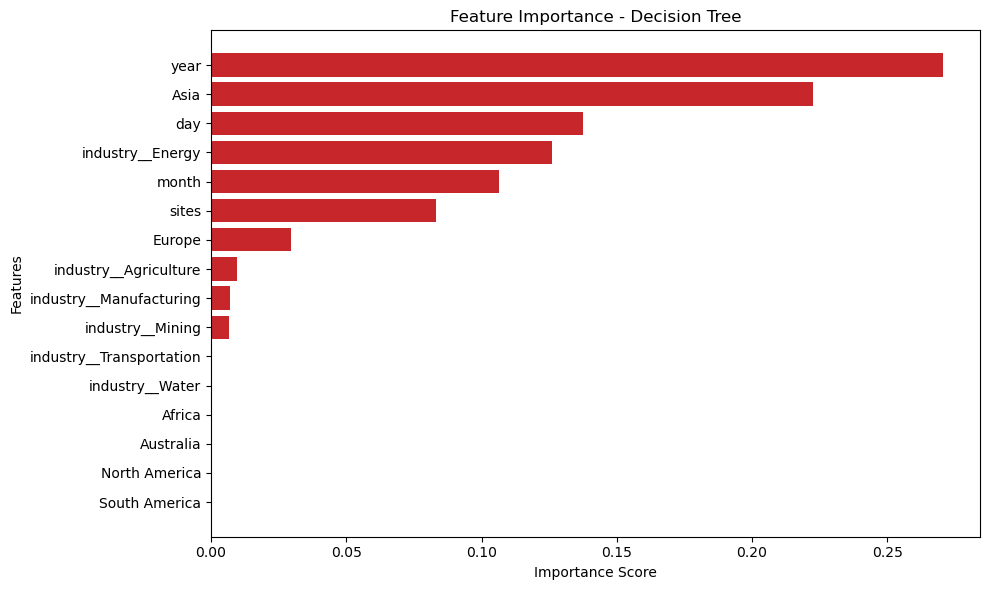

In [66]:
feature_importances = dt_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center', color=denexus_colors[2])
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - Decision Tree')
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "feature-importance_decision-tree.png")
    plt.savefig(output_path)
plt.show()

In [67]:
cv_scores = cross_val_score(dt_model, X_train_ros, y_train_ros, cv=5, scoring='accuracy')
cv_scores

array([0.92982456, 0.98245614, 0.94736842, 0.96491228, 0.89285714])

In [68]:
print("Train set score (Accuracy) =", dt_model.score(X_train_ros, y_train_ros))
print("Test set score (Accuracy) =", dt_model.score(X_test, y_test))

# Matriz de confusión
conf_mat = confusion_matrix(y_test, dt_model.predict(X_test))

# Imprimir la matriz de confusión con un formato bonito
print(tabulate(conf_mat, 
               headers=[f'Pred Class {i}' for i in range(4)], 
               showindex=[f'Real Class {i}' for i in range(4)], 
               tablefmt='fancy_grid'))

# Reporte de clasificación
print("\nClassification Report:")
print(classification_report(y_test, dt_model.predict(X_test)))

Train set score (Accuracy) = 1.0
Test set score (Accuracy) = 0.5217391304347826
╒══════════════╤════════════════╤════════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │   Pred Class 2 │   Pred Class 3 │
╞══════════════╪════════════════╪════════════════╪════════════════╪════════════════╡
│ Real Class 0 │              0 │              0 │              1 │              0 │
├──────────────┼────────────────┼────────────────┼────────────────┼────────────────┤
│ Real Class 1 │              0 │              1 │              1 │              0 │
├──────────────┼────────────────┼────────────────┼────────────────┼────────────────┤
│ Real Class 2 │              1 │              3 │             11 │              1 │
├──────────────┼────────────────┼────────────────┼────────────────┼────────────────┤
│ Real Class 3 │              0 │              0 │              4 │              0 │
╘══════════════╧════════════════╧════════════════╧════════════════╧═══

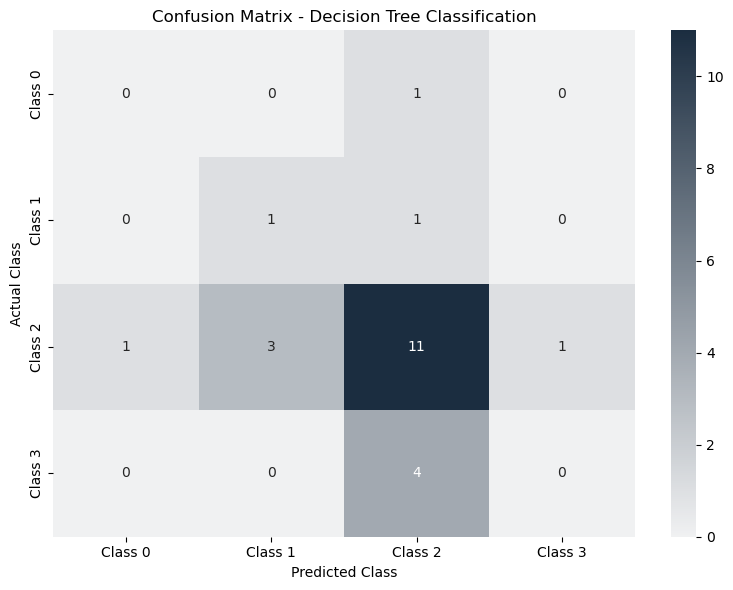

In [69]:
class_labels = [f'Class {i}' for i in range(conf_mat.shape[0])]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=denexus_palette,
            xticklabels=class_labels, yticklabels=class_labels, cbar=True)
plt.title('Confusion Matrix - Decision Tree Classification')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "confusion-matrix_decision-tree.png")
    plt.savefig(output_path)
plt.show()

**Conclusiones.**

En los resultados mostrados, el modelo de **Árbol de Decisión** presenta un excelente rendimiento en el conjunto de **entrenamiento**, logrando una precisión perfecta. Sin embargo, en el conjunto de **prueba**, la precisión es significativamente más baja, lo que sugiere que el modelo está **sobreajustado** a los datos de entrenamiento y no generaliza bien a datos no vistos.

El reporte de clasificación indica que el modelo tiene un rendimiento aceptable para algunas clases, especialmente para aquellas con mayor representación en los datos. Sin embargo, para las clases minoritarias, el desempeño es considerablemente más bajo. Esto refleja que, a pesar de haber realizado **oversampling** y ajustar los **pesos de clase** para las clases menos representadas, el modelo sigue teniendo dificultades para predecir correctamente estas clases. Es un indicio de que el ajuste de pesos y el oversampling no han sido suficientes para mejorar la capacidad de predicción de las clases minoritarias.

La **precisión** global del modelo en el conjunto de prueba no es ideal, lo que está relacionado con el desbalance de clases persistente. Aunque las técnicas de **oversampling** y ajuste de pesos han mejorado el rendimiento respecto a las clases más representadas, el modelo sigue enfrentando retos al predecir las clases minoritarias. La **media ponderada** de las métricas muestra un desempeño moderado, indicando que el modelo, en general, tiene un rendimiento aceptable, pero aún puede mejorarse, especialmente en la predicción de las clases menos frecuentes.

In [70]:
df.to_csv('./data/WATERFALL_cleaned.csv')

#### Resultados.

In [71]:
rf_pred = rf_model.predict(X_test)
dt_pred = dt_model.predict(X_test)

In [72]:
rf_precision = precision_score(y_test, rf_pred, average='weighted')
rf_recall = recall_score(y_test, rf_pred, average='weighted')

In [73]:
dt_precision = precision_score(y_test, dt_pred, average='weighted')
dt_recall = recall_score(y_test, dt_pred, average='weighted')

In [74]:
results['Model'] = ['RandomForest', 'DecisionTree']
results['Accuracy'] = [rf_precision, dt_precision]
results['Recall'] = [rf_recall, dt_recall]

In [75]:
results

,Model,Tipo,Accuracy,Recall
0,RandomForest,LabelEncoder,0.729977,0.695652
1,DecisionTree,LabelEncoder,0.471867,0.521739


## Visualización de datos.

### Number of Incidents by Continent.

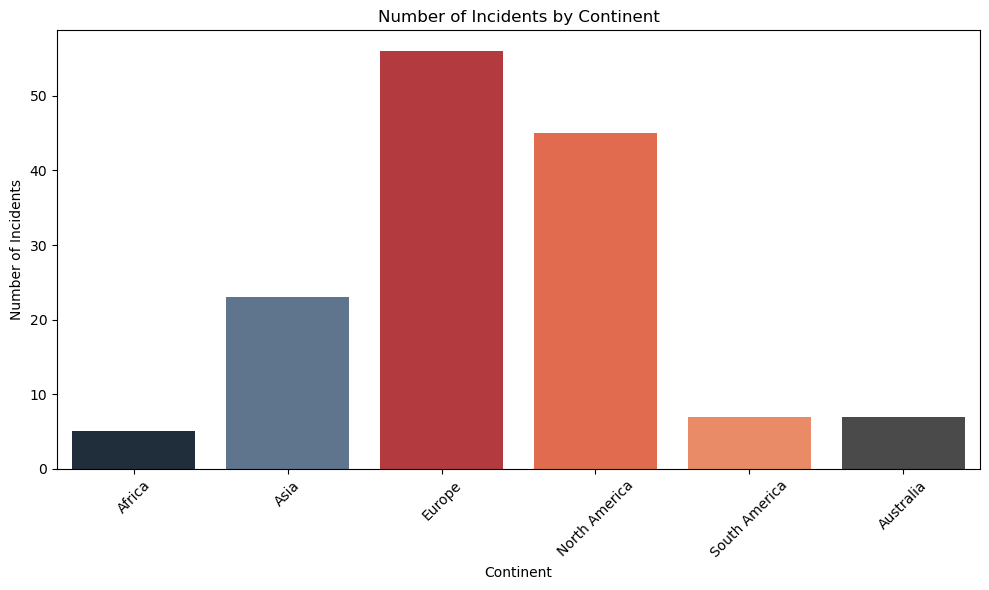

In [76]:
continent_counts = df[['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Australia']].sum()

plt.figure(figsize=(10, 6))
sns.barplot(x=continent_counts.index, y=continent_counts.values, palette=denexus_colors)
plt.title('Number of Incidents by Continent')
plt.xlabel('Continent')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "number-incidents-continent.png")
    plt.savefig(output_path)
plt.show()

### Comparison of Incidents by Industry Over Years.

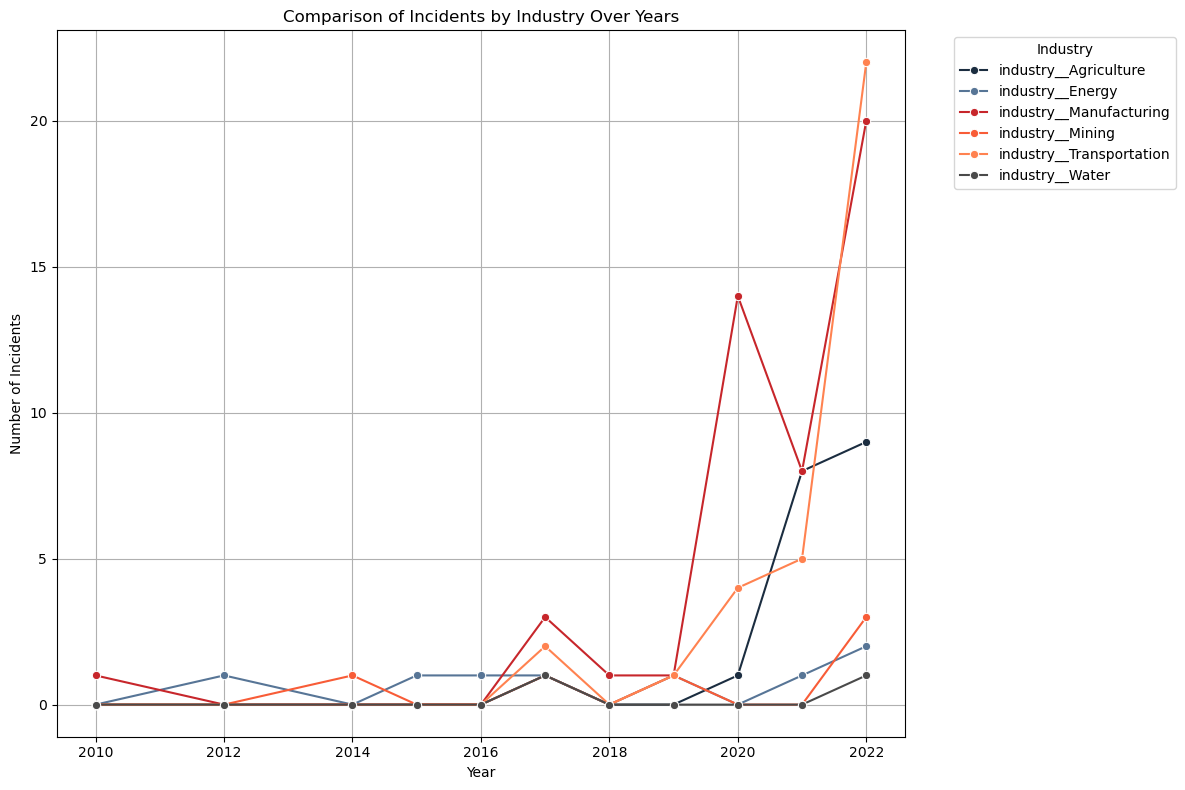

In [238]:
incidents_by_year_and_industry = df.groupby('year')[df.filter(like='industry_').columns].sum()

plt.figure(figsize=(12, 8))
for idx, column in enumerate(incidents_by_year_and_industry.columns):
    sns.lineplot(
        data=incidents_by_year_and_industry,
        x=incidents_by_year_and_industry.index,
        y=incidents_by_year_and_industry[column],
        marker='o',
        label=column,
        color=denexus_colors[idx % len(denexus_colors)]
    )

plt.title('Comparison of Incidents by Industry Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "comparasion-incidents-industry.png")
    plt.savefig(output_path)
plt.show()